# 04_preprocessing_clinical.ipynb - Preprocesamiento de Datos Clínicos

## Introducción

Este notebook implementa el preprocesamiento de los datos clínicos del proyecto de Monitorización Multimodal de Alzheimer. Trabajaremos con los conjuntos de datos CDR.csv (Clinical Dementia Rating) y DXSUM.csv (Diagnóstico), aplicando las recomendaciones derivadas del análisis exploratorio previo.


***

## 1. Configuración inicial

In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

%matplotlib inline

## 2. Carga de datos

In [4]:
# Definir la ruta a los datos (ajustar según sea necesario)
data_path = "../data/raw/adni/clinical/"

# Cargar los datasets
cdr_df = pd.read_csv(os.path.join(data_path, "CDR.csv"))
dx_df = pd.read_csv(os.path.join(data_path, "DXSUM.csv"))

print(f"CDR dataset: {cdr_df.shape[0]} filas, {cdr_df.shape[1]} columnas")
print(f"DXSUM dataset: {dx_df.shape[0]} filas, {dx_df.shape[1]} columnas")

CDR dataset: 14102 filas, 25 columnas
DXSUM dataset: 14880 filas, 41 columnas


## 3. Preprocesamiento de los datos CDR

### 3.1 Selección de variables relevantes y limpieza básica

In [5]:
# Seleccionar columnas relevantes del dataset CDR
cdr_relevant = cdr_df[['PTID', 'RID', 'VISCODE', 'VISCODE2', 'VISDATE', 
                       'CDMEMORY', 'CDORIENT', 'CDJUDGE', 'CDCOMMUN',
                       'CDHOME', 'CDCARE', 'CDGLOBAL', 'CDRSB']]

# Convertir fecha de visita a datetime
cdr_relevant['VISDATE'] = pd.to_datetime(cdr_relevant['VISDATE'], errors='coerce')

# Verificar valores faltantes
print("Valores faltantes en dataset CDR:")
print(cdr_relevant.isnull().sum())

Valores faltantes en dataset CDR:
PTID          0
RID           0
VISCODE       0
VISCODE2     15
VISDATE       7
CDMEMORY     96
CDORIENT     95
CDJUDGE      95
CDCOMMUN     96
CDHOME       96
CDCARE       96
CDGLOBAL    101
CDRSB       230
dtype: int64


### 3.2 Imputación de valores faltantes basada en diagnóstico

In [6]:
display(cdr_df.columns)
display(dx_df.columns)

Index(['PHASE', 'PTID', 'RID', 'VISCODE', 'VISCODE2', 'VISDATE', 'CDSOURCE',
       'CDVERSION', 'SPID', 'CDMEMORY', 'CDORIENT', 'CDJUDGE', 'CDCOMMUN',
       'CDHOME', 'CDCARE', 'CDGLOBAL', 'CDRSB', 'ID', 'SITEID', 'USERDATE',
       'USERDATE2', 'DD_CRF_VERSION_LABEL', 'LANGUAGE_CODE', 'HAS_QC_ERROR',
       'update_stamp'],
      dtype='object')

Index(['PHASE', 'PTID', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'DIAGNOSIS',
       'DXNORM', 'DXNODEP', 'DXMCI', 'DXMDES', 'DXMPTR1', 'DXMPTR2', 'DXMPTR3',
       'DXMPTR4', 'DXMPTR5', 'DXMPTR6', 'DXMDUE', 'DXMOTHET', 'DXDSEV',
       'DXDDUE', 'DXAD', 'DXAPP', 'DXAPROB', 'DXAPOSS', 'DXPARK', 'DXPDES',
       'DXPCOG', 'DXPATYP', 'DXDEP', 'DXOTHDEM', 'DXODES', 'DXCONFID', 'ID',
       'SITEID', 'USERDATE', 'USERDATE2', 'DD_CRF_VERSION_LABEL',
       'LANGUAGE_CODE', 'HAS_QC_ERROR', 'update_stamp'],
      dtype='object')

In [7]:
display(dx_df['DIAGNOSIS'].unique())

array([ 1.,  3.,  2., nan])

In [8]:
# Primero unimos temporalmente con dx_df para tener la información de diagnóstico
dx_temp = dx_df[['PTID', 'RID', 'VISCODE', 'VISCODE2', 'DIAGNOSIS']]
cdr_with_dx = pd.merge(cdr_relevant, dx_temp, on=['PTID', 'RID', 'VISCODE', 'VISCODE2'], how='left')

# Función para imputación por subgrupo diagnóstico
def impute_by_diagnosis(df, target_cols):
    # Crear una copia para no modificar el original durante la iteración
    result_df = df.copy()
    
    # Agrupar por diagnóstico para la imputación específica
    diagnosis_groups = ['CN', 'MCI', 'AD', 'Unknown']
    
    for diag in diagnosis_groups:
        if diag == 'Unknown':
            mask = df['DIAGNOSIS'].isnull()
        else:
            mask = df['DIAGNOSIS'] == diag
            
        if mask.sum() > 0:
            # Para cada grupo diagnóstico con suficientes datos, aplicar KNN
            group_df = df[mask]
            if group_df.shape[0] > 10:  # Verificar que hay suficientes datos
                imputer = KNNImputer(n_neighbors=5)
                # Aplicar imputación solo a las columnas objetivo
                cols_to_impute = [col for col in target_cols if group_df[col].isnull().any()]
                if cols_to_impute:
                    imputed_values = imputer.fit_transform(group_df[cols_to_impute])
                    result_df.loc[mask, cols_to_impute] = imputed_values
            else:
                # Si hay pocos datos, usar la mediana del grupo
                for col in target_cols:
                    if group_df[col].isnull().any():
                        median_val = group_df[col].median()
                        result_df.loc[mask & df[col].isnull(), col] = median_val
    
    return result_df

# Columnas CDR para imputar
cdr_components = ['CDMEMORY', 'CDORIENT', 'CDJUDGE', 'CDCOMMUN', 'CDHOME', 'CDCARE', 'CDGLOBAL']

# Aplicar imputación
cdr_imputed = impute_by_diagnosis(cdr_with_dx, cdr_components)

# Recalcular CDRSB para casos donde se imputaron componentes pero CDRSB es NA
mask_recalc = cdr_imputed['CDRSB'].isnull() & cdr_imputed[cdr_components].notna().all(axis=1)
cdr_imputed.loc[mask_recalc, 'CDRSB'] = cdr_imputed.loc[mask_recalc, cdr_components].sum(axis=1)

# Verificar imputación
print("\nValores faltantes después de imputación:")
print(cdr_imputed[cdr_components + ['CDRSB']].isnull().sum())

# Eliminar la columna de diagnóstico que habíamos agregado temporalmente
cdr_processed = cdr_imputed.drop(columns=['DIAGNOSIS'])


Valores faltantes después de imputación:
CDMEMORY    74
CDORIENT    74
CDJUDGE     74
CDCOMMUN    75
CDHOME      75
CDCARE      75
CDGLOBAL    77
CDRSB       75
dtype: int64


### 3.3 Crear variables derivadas para capturar cambios longitudinales

In [9]:
# Ordenar datos por paciente y fecha de visita
cdr_processed = cdr_processed.sort_values(['PTID', 'VISDATE'])

# Función para calcular cambios entre visitas
def calculate_longitudinal_changes(df):
    # Crear una copia para no modificar el original
    result_df = df.copy()
    
    # Inicializar columnas de cambio
    result_df['CDRSB_CHANGE'] = np.nan
    result_df['CDRSB_CHANGE_ANNUAL'] = np.nan
    result_df['DAYS_SINCE_BASELINE'] = np.nan
    
    # Procesar cada paciente
    for patient_id in df['PTID'].unique():
        patient_data = df[df['PTID'] == patient_id].copy()
        patient_data = patient_data.sort_values('VISDATE')
        
        if len(patient_data) <= 1:
            continue  # Saltar pacientes con una sola visita
            
        # Calcular días desde la visita inicial
        baseline_date = patient_data['VISDATE'].iloc[0]
        patient_data['DAYS_SINCE_BASELINE'] = (patient_data['VISDATE'] - baseline_date).dt.days
        
        # Calcular cambios en CDRSB
        patient_data['PREV_CDRSB'] = patient_data['CDRSB'].shift(1)
        patient_data['PREV_DATE'] = patient_data['VISDATE'].shift(1)
        mask = ~patient_data['PREV_CDRSB'].isnull()
        
        if mask.sum() > 0:
            # Cambio absoluto
            patient_data.loc[mask, 'CDRSB_CHANGE'] = patient_data.loc[mask, 'CDRSB'] - patient_data.loc[mask, 'PREV_CDRSB']
            
            # Cambio anualizado (ajustado por tiempo entre visitas)
            days_diff = (patient_data.loc[mask, 'VISDATE'] - patient_data.loc[mask, 'PREV_DATE']).dt.days
            patient_data.loc[mask, 'CDRSB_CHANGE_ANNUAL'] = patient_data.loc[mask, 'CDRSB_CHANGE'] * 365.25 / days_diff
            
        # Actualizar el dataframe principal
        result_df.loc[patient_data.index, 'CDRSB_CHANGE'] = patient_data['CDRSB_CHANGE']
        result_df.loc[patient_data.index, 'CDRSB_CHANGE_ANNUAL'] = patient_data['CDRSB_CHANGE_ANNUAL']
        result_df.loc[patient_data.index, 'DAYS_SINCE_BASELINE'] = patient_data['DAYS_SINCE_BASELINE']
    
    # Eliminar columnas temporales si se han añadido al dataframe resultante
    if 'PREV_CDRSB' in result_df.columns:
        result_df = result_df.drop(columns=['PREV_CDRSB', 'PREV_DATE'])

    # Manejo de outliers: winsorización al 5–95%
    for col in ['CDRSB_CHANGE', 'CDRSB_CHANGE_ANNUAL']:
        if col in result_df.columns:
            lo, hi = result_df[col].quantile([0.05, 0.95])
            result_df[f'{col}_winsorized'] = result_df[col].clip(lower=lo, upper=hi)

    return result_df

# Aplicar cálculo de cambios longitudinales
cdr_processed = calculate_longitudinal_changes(cdr_processed)

# Verificar las nuevas variables
print("\nEstadísticas de cambios longitudinales:")
print(cdr_processed[['CDRSB_CHANGE', 'CDRSB_CHANGE_ANNUAL']].describe())


Estadísticas de cambios longitudinales:
       CDRSB_CHANGE  CDRSB_CHANGE_ANNUAL
count   9888.000000          9878.000000
mean       0.381259                 -inf
std        1.829429                  NaN
min      -24.000000                 -inf
25%        0.000000             0.000000
50%        0.000000             0.000000
75%        0.500000             0.857394
max       24.000000           182.625000


## 4. Preprocesamiento de los datos de Diagnóstico (DXSUM)

### 4.1 Selección de variables relevantes y limpieza básica

In [10]:
# Seleccionar columnas relevantes del dataset de diagnóstico
dx_relevant = dx_df[['PTID', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 
                     'DIAGNOSIS', 'DXNORM', 'DXMCI', 'DXAD', 
                     'DXPARK', 'DXDEP', 'DXOTHDEM']]

# Convertir fecha de examen a datetime
dx_relevant['EXAMDATE'] = pd.to_datetime(dx_relevant['EXAMDATE'], errors='coerce')

# Verificar valores faltantes
print("\nValores faltantes en dataset de diagnóstico:")
print(dx_relevant.isnull().sum())


Valores faltantes en dataset de diagnóstico:
PTID             0
RID              0
VISCODE          0
VISCODE2        14
EXAMDATE        93
DIAGNOSIS       38
DXNORM       11012
DXMCI        11012
DXAD         11012
DXPARK         139
DXDEP         4477
DXOTHDEM     11012
dtype: int64


### 4.2 Implementar codificación ordinal para DIAGNOSIS

In [13]:
# Crear variable de diagnóstico ordinal
def map_diagnosis_to_ordinal(diagnosis):
    if pd.isnull(diagnosis):
        return np.nan
    elif diagnosis == 'CN':
        return 0  # Normal
    elif diagnosis == 'MCI':
        return 1  # MCI
    elif diagnosis == 'Dementia':
        return 2  # Asumimos demencia leve por defecto
    else:
        return np.nan  # Otros valores

# Aplicar mapeo
dx_relevant['DIAGNOSIS_ORDINAL'] = dx_relevant['DIAGNOSIS'].apply(map_diagnosis_to_ordinal)

# Ajustar severidad para pacientes con demencia basado en CDR Global
# Primero fusionar con CDR para obtener CDGLOBAL
dx_with_cdr = pd.merge(
    dx_relevant,
    cdr_df[['PTID', 'RID', 'VISCODE', 'VISCODE2', 'CDGLOBAL']],
    on=['PTID', 'RID', 'VISCODE', 'VISCODE2'],
    how='left'
)

# Ajustar la severidad para pacientes con demencia basado en CDGLOBAL
# CDGLOBAL: 0=Normal, 0.5=Muy leve, 1=Leve, 2=Moderado, 3=Severo
def adjust_dementia_severity(row):
    if row['DIAGNOSIS_ORDINAL'] == 2 and not pd.isnull(row['CDGLOBAL']):
        if row['CDGLOBAL'] == 1:
            return 2  # Demencia leve
        elif row['CDGLOBAL'] == 2:
            return 3  # Demencia moderada
        elif row['CDGLOBAL'] == 3:
            return 4  # Demencia severa
    return row['DIAGNOSIS_ORDINAL']

dx_with_cdr['DIAGNOSIS_ORDINAL'] = dx_with_cdr.apply(adjust_dementia_severity, axis=1)

# Eliminar la columna CDGLOBAL que usamos temporalmente
dx_processed = dx_with_cdr.drop(columns=['CDGLOBAL'])

# Verificar la distribución de la variable ordinal
print("\nDistribución de diagnóstico ordinal:")
print(dx_processed['DIAGNOSIS_ORDINAL'].value_counts(dropna=False))


Distribución de diagnóstico ordinal:
DIAGNOSIS_ORDINAL
NaN    14880
Name: count, dtype: int64


### 4.3 Crear variables binarias para comorbilidades

In [14]:
# Convertir variables de comorbilidad a formato binario (1=presente, 0=ausente)
comorbidity_vars = ['DXPARK', 'DXDEP', 'DXOTHDEM']

for var in comorbidity_vars:
    # Asumir que cualquier valor distinto de 0 o NaN indica presencia
    dx_processed[f'{var}_BINARY'] = dx_processed[var].apply(
        lambda x: 1 if not pd.isnull(x) and x != 0 else 0
    )

# Verificar las nuevas variables binarias
print("\nDistribución de comorbilidades binarias:")
for var in comorbidity_vars:
    print(f"{var}_BINARY:", dx_processed[f'{var}_BINARY'].value_counts())


Distribución de comorbilidades binarias:
DXPARK_BINARY: DXPARK_BINARY
0    10877
1     4003
Name: count, dtype: int64
DXDEP_BINARY: DXDEP_BINARY
0    13934
1      946
Name: count, dtype: int64
DXOTHDEM_BINARY: DXOTHDEM_BINARY
0    11012
1     3868
Name: count, dtype: int64


### 4.4 Calcular transiciones diagnósticas

In [16]:
# Función para calcular transiciones diagnósticas
def calculate_diagnostic_transitions(df):
    # Crear una copia para no modificar el original
    result_df = df.copy()
    
    # Inicializar columnas EN EL DATAFRAME PRINCIPAL
    result_df['DIAGNOSIS_PREV'] = np.nan
    result_df['DIAGNOSIS_TRANSITION'] = np.nan  # <-- Añadir inicialización aquí
    result_df['DAYS_TO_TRANSITION'] = np.nan
    
    # Procesar cada paciente
    for patient_id in df['PTID'].unique():
        patient_data = df[df['PTID'] == patient_id].copy()
        patient_data = patient_data.sort_values('EXAMDATE')
        
        # Inicializar columnas EN EL DATAFRAME DEL PACIENTE <-- Solución clave
        patient_data['DIAGNOSIS_TRANSITION'] = np.nan  
        patient_data['DAYS_TO_TRANSITION'] = np.nan     
        
        if len(patient_data) <= 1:
            continue
            
        # Calcular diagnóstico previo y transiciones
        patient_data['DIAGNOSIS_PREV'] = patient_data['DIAGNOSIS_ORDINAL'].shift(1)
        patient_data['PREV_DATE'] = patient_data['EXAMDATE'].shift(1)
        mask = ~patient_data['DIAGNOSIS_PREV'].isnull()
        
        if mask.sum() > 0:
            # Calcular transición 
            patient_data.loc[mask, 'DIAGNOSIS_TRANSITION'] = (
                patient_data.loc[mask, 'DIAGNOSIS_ORDINAL'] - 
                patient_data.loc[mask, 'DIAGNOSIS_PREV']
            )
            
            # Calcular días hasta la transición
            days_diff = (patient_data.loc[mask, 'EXAMDATE'] - patient_data.loc[mask, 'PREV_DATE']).dt.days
            patient_data.loc[mask, 'DAYS_TO_TRANSITION'] = days_diff
            
        # Actualizar el dataframe principal
        result_df.loc[patient_data.index, 'DIAGNOSIS_PREV'] = patient_data['DIAGNOSIS_PREV']
        result_df.loc[patient_data.index, 'DIAGNOSIS_TRANSITION'] = patient_data['DIAGNOSIS_TRANSITION']  # Ya existe
        result_df.loc[patient_data.index, 'DAYS_TO_TRANSITION'] = patient_data['DAYS_TO_TRANSITION']
    
    # Eliminar columnas temporales
    result_df = result_df.drop(columns=['PREV_DATE'], errors='ignore')
        
    return result_df

# Aplicar cálculo de transiciones diagnósticas
dx_processed = calculate_diagnostic_transitions(dx_processed)

# Verificar las nuevas variables
print("\nEstadísticas de transiciones diagnósticas:")
print(dx_processed['DIAGNOSIS_TRANSITION'].value_counts(dropna=False))
print("\nDías hasta transición (estadísticas):")
print(dx_processed['DAYS_TO_TRANSITION'].describe())


Estadísticas de transiciones diagnósticas:
DIAGNOSIS_TRANSITION
NaN    14880
Name: count, dtype: int64

Días hasta transición (estadísticas):
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: DAYS_TO_TRANSITION, dtype: float64


## 5. Integración de datos CDR y diagnóstico

In [18]:
# Fusionar datasets de CDR y diagnóstico
clinical_integrated = pd.merge(
    cdr_processed,
    dx_processed,
    on=['RID', 'VISCODE'],
    how='outer',
    suffixes=('_CDR', '_DX')
)

# Consolidar fechas (pueden diferir ligeramente entre CDR y diagnóstico)
clinical_integrated['VISIT_DATE'] = clinical_integrated['VISDATE'].combine_first(clinical_integrated['EXAMDATE'])

# Verificar duplicados
duplicates = clinical_integrated.duplicated(subset=['RID', 'VISIT_DATE'], keep=False)
print("Registros duplicados:", duplicates.sum())
print("="*90)

# Verificar el resultado de la fusión
print("\nDimensiones del dataset integrado:")
print(f"Filas: {clinical_integrated.shape[0]}, Columnas: {clinical_integrated.shape[1]}")
print("\nValores faltantes en el dataset integrado:")
print(clinical_integrated[['CDRSB', 'DIAGNOSIS_ORDINAL']].isnull().sum())

Registros duplicados: 30

Dimensiones del dataset integrado:
Filas: 16917, Columnas: 36

Valores faltantes en el dataset integrado:
CDRSB                 2890
DIAGNOSIS_ORDINAL    16917
dtype: int64


### Análisis de inconsistencias temporales

In [21]:
# Análisis de inconsistencias temporales

date_discrepancies = clinical_integrated[
    (clinical_integrated['VISDATE'] != clinical_integrated['EXAMDATE']) 
    & clinical_integrated['VISDATE'].notna() 
    & clinical_integrated['EXAMDATE'].notna()
]

display(date_discrepancies.shape)

(7139, 36)

## 6. Transformaciones adicionales para análisis estadísticos

In [23]:
# Transformación logarítmica de CDRSB para distribución más normal 
# (añadimos 0.1 para evitar log(0))
clinical_integrated['CDRSB_LOG'] = np.log1p(clinical_integrated['CDRSB'])

# Categorización de CDRSB según umbrales clínicos identificados en el EDA
def categorize_cdrsb(cdrsb):
    if pd.isnull(cdrsb):
        return np.nan
    elif cdrsb < 1.0:
        return 0  # Normal
    elif cdrsb <= 4.0:
        return 1  # Consistente con MCI
    else:
        return 2  # Sugestivo de demencia

clinical_integrated['CDRSB_CATEGORY'] = clinical_integrated['CDRSB'].apply(categorize_cdrsb)

# Verificar distribución
print("\nDistribución de categorías CDRSB:")
print(clinical_integrated['CDRSB_CATEGORY'].value_counts(dropna=False))


Distribución de categorías CDRSB:
CDRSB_CATEGORY
0.0    6545
1.0    5399
NaN    2890
2.0    2083
Name: count, dtype: int64


## 7. Limpieza final y exportación de datos

In [24]:
# Eliminar filas donde faltan tanto CDRSB como diagnóstico (no aportan valor)
clinical_clean = clinical_integrated.dropna(subset=['CDRSB', 'DIAGNOSIS_ORDINAL'], how='all')

# Seleccionar columnas en orden lógico
final_columns = [
    # Identificadores y metadata
    'PTID', 'RID', 'VISCODE', 'VISCODE2', 'VISIT_DATE', 
    'DAYS_SINCE_BASELINE',
    
    # Variables CDR originales
    'CDMEMORY', 'CDORIENT', 'CDJUDGE', 'CDCOMMUN', 'CDHOME', 'CDCARE', 'CDGLOBAL', 'CDRSB',
    
    # Variables CDR derivadas
    'CDRSB_LOG', 'CDRSB_CATEGORY', 'CDRSB_CHANGE', 'CDRSB_CHANGE_ANNUAL',
    
    # Variables de diagnóstico originales
    'DIAGNOSIS', 'DXNORM', 'DXMCI', 'DXAD',
    
    # Variables de diagnóstico derivadas
    'DIAGNOSIS_ORDINAL', 'DIAGNOSIS_PREV', 'DIAGNOSIS_TRANSITION', 'DAYS_TO_TRANSITION',
    
    # Comorbilidades
    'DXPARK_BINARY', 'DXDEP_BINARY', 'DXOTHDEM_BINARY'
]

# Verificar que todas las columnas existen
existing_columns = [col for col in final_columns if col in clinical_clean.columns]
clinical_final = clinical_clean[existing_columns]

# Guardar el dataset procesado
processed_path = "../data/processed/"
os.makedirs(processed_path, exist_ok=True)
clinical_final.to_csv(os.path.join(processed_path, "clinical_processed.csv"), index=False)

print("="*100)
print(f"\nDatos clínicos procesados guardados en {processed_path}clinical_processed.csv")
print(f"Dimensiones finales: {clinical_final.shape[0]} filas, {clinical_final.shape[1]} columnas")


Datos clínicos procesados guardados en ../data/processed/clinical_processed.csv
Dimensiones finales: 14027 filas, 27 columnas


## 8. Resumen de las transformaciones realizadas

In [25]:
# Mostramos un resumen de las transformaciones aplicadas
transformations = {
    "Imputación": "Implementada por subgrupo diagnóstico para preservar relaciones clínicas",
    "Variables longitudinales": "Creadas CDRSB_CHANGE y CDRSB_CHANGE_ANNUAL para capturar progresión",
    "Codificación diagnóstica": "Implementada escala ordinal (0=Normal a 4=Demencia severa)",
    "Comorbilidades": "Convertidas a formato binario para facilitar análisis",
    "Transiciones": "Calculadas transiciones diagnósticas y días entre cambios",
    "Transformaciones": "Aplicada transformación logarítmica a CDRSB",
    "Categorización": "Implementados umbrales clínicos para CDRSB (<1.0=Normal, 1.0-4.0=MCI, >4.0=Demencia)"
}

print("\nResumen de transformaciones aplicadas:")
for category, description in transformations.items():
    print(f"- {category}: {description}")


Resumen de transformaciones aplicadas:
- Imputación: Implementada por subgrupo diagnóstico para preservar relaciones clínicas
- Variables longitudinales: Creadas CDRSB_CHANGE y CDRSB_CHANGE_ANNUAL para capturar progresión
- Codificación diagnóstica: Implementada escala ordinal (0=Normal a 4=Demencia severa)
- Comorbilidades: Convertidas a formato binario para facilitar análisis
- Transiciones: Calculadas transiciones diagnósticas y días entre cambios
- Transformaciones: Aplicada transformación logarítmica a CDRSB
- Categorización: Implementados umbrales clínicos para CDRSB (<1.0=Normal, 1.0-4.0=MCI, >4.0=Demencia)


## 9. Visualización de resultados clave del preprocesamiento

In [28]:
print("===Conteo por categoría diagnóstica:")
print(clinical_final['DIAGNOSIS_ORDINAL'].value_counts(dropna=False))

print("\n===Valores faltantes en CDRSB_CHANGE_ANNUAL por categoría:")
print(clinical_final.groupby('DIAGNOSIS_ORDINAL')['CDRSB_CHANGE_ANNUAL'].apply(lambda x: x.isnull().sum()))

===Conteo por categoría diagnóstica:
DIAGNOSIS_ORDINAL
NaN    14027
Name: count, dtype: int64

===Valores faltantes en CDRSB_CHANGE_ANNUAL por categoría:
Series([], Name: CDRSB_CHANGE_ANNUAL, dtype: float64)


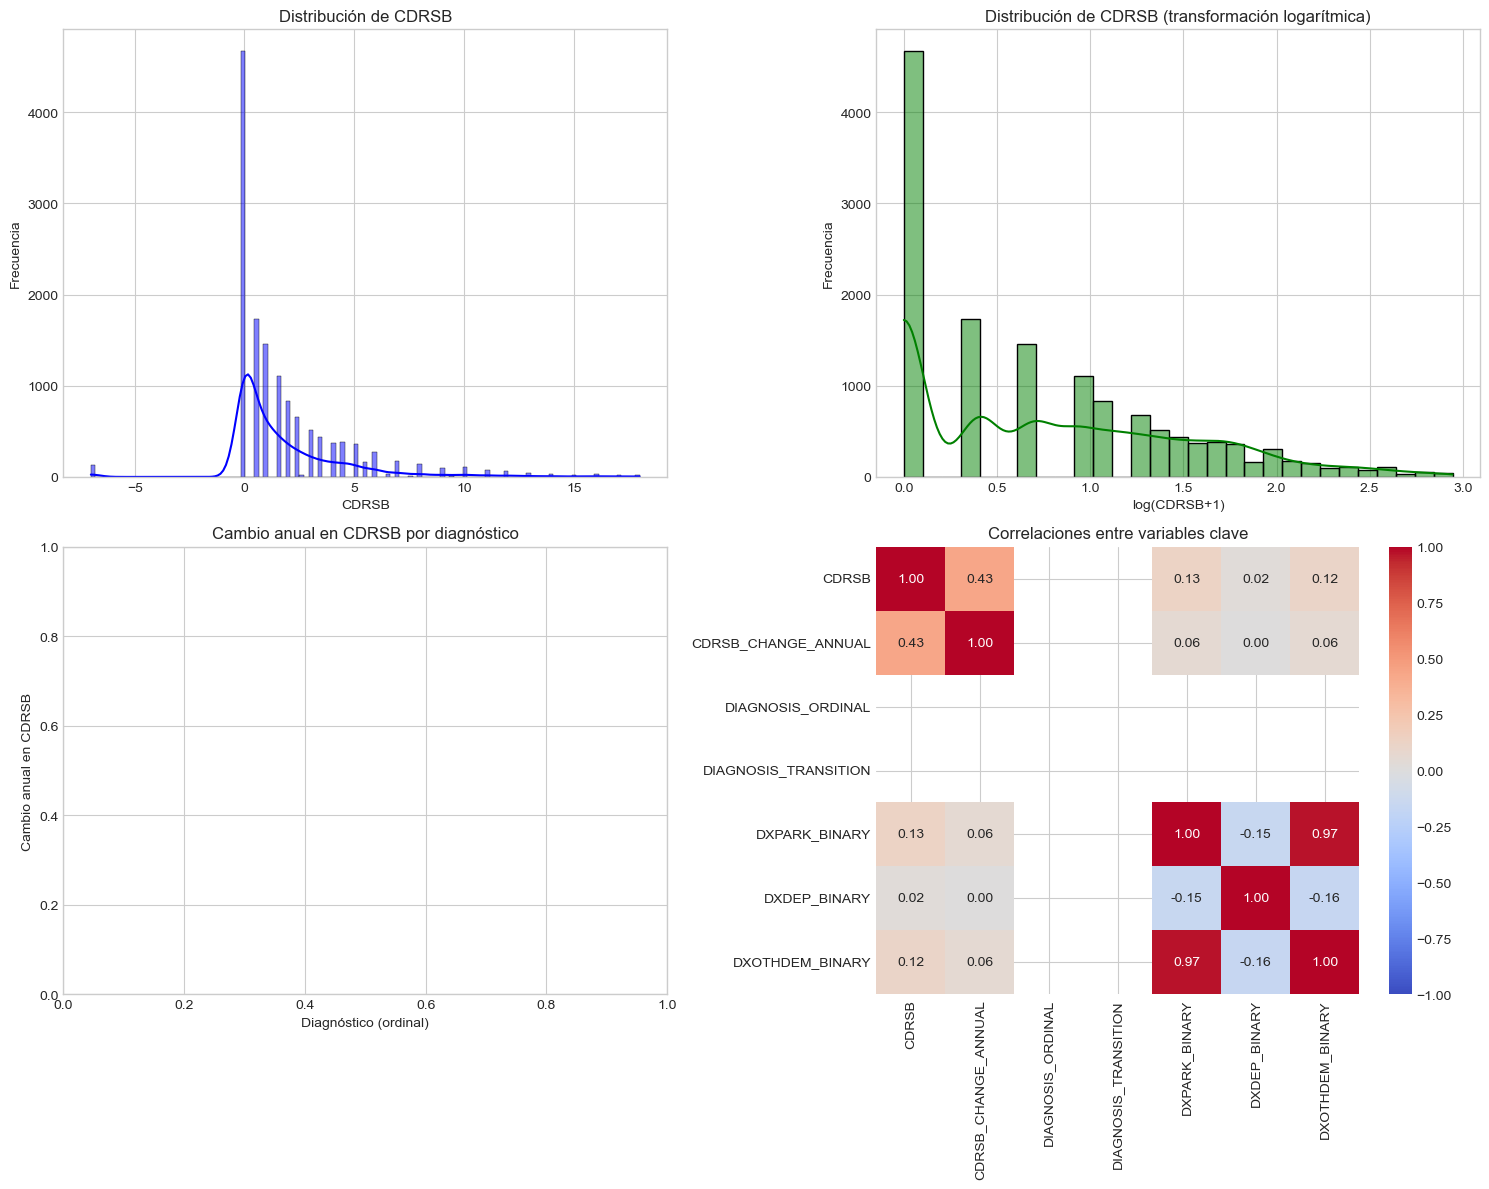


Gráfico resumen guardado en: ..\reports\figures\clinical_preprocessing_summary.png


In [32]:
reports_path = r"..\reports\figures"

# Configuración de visualización
plt.figure(figsize=(15, 12))

# 1. Comparación de distribución original vs transformada de CDRSB
plt.subplot(2, 2, 1)
sns.histplot(clinical_final['CDRSB'], kde=True, color='blue', label='Original')
plt.title('Distribución de CDRSB')
plt.xlabel('CDRSB')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 2)
sns.histplot(clinical_final['CDRSB_LOG'], kde=True, color='green', label='Log-transformada')
plt.title('Distribución de CDRSB (transformación logarítmica)')
plt.xlabel('log(CDRSB+1)')
plt.ylabel('Frecuencia')

# 2. Cambio anual en CDRSB por categoría diagnóstica
plt.subplot(2, 2, 3)
# Filtrar datos antes de plotear
valid_data = clinical_final.dropna(subset=['CDRSB_CHANGE_ANNUAL', 'DIAGNOSIS_ORDINAL'])
sns.boxplot(
    x='DIAGNOSIS_ORDINAL', 
    y='CDRSB_CHANGE_ANNUAL', 
    data=valid_data,
    order=sorted(valid_data['DIAGNOSIS_ORDINAL'].unique())  # Asegurar orden consistente
)
plt.title('Cambio anual en CDRSB por diagnóstico')
plt.xlabel('Diagnóstico (ordinal)')
plt.ylabel('Cambio anual en CDRSB')

# 3. Matriz de correlación de variables clave
plt.subplot(2, 2, 4)
corr_vars = ['CDRSB', 'CDRSB_CHANGE_ANNUAL', 'DIAGNOSIS_ORDINAL', 'DIAGNOSIS_TRANSITION', 
             'DXPARK_BINARY', 'DXDEP_BINARY', 'DXOTHDEM_BINARY']
corr_matrix = clinical_final[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlaciones entre variables clave')

plt.tight_layout()
plt.savefig(os.path.join(reports_path, "clinical_preprocessing_summary.png"))
plt.show()

print("\nGráfico resumen guardado en:", os.path.join(reports_path, "clinical_preprocessing_summary.png"))

## 10. Distribución de muestras por grupo diagnóstico y visita

In [37]:
# Tabla cruzada de diagnóstico por visita
visit_diag_counts = pd.crosstab(
    clinical_final['VISCODE'], 
    clinical_final['DIAGNOSIS_ORDINAL'],
    margins=True
)

print("\nDistribución de diagnósticos por visita:")
print(visit_diag_counts)

# Visualizar distribución
plt.figure(figsize=(12, 6))

plot_data = visit_diag_counts.copy()

# Eliminar 'All' solo si existen
if 'All' in plot_data.index:
    plot_data = plot_data.drop('All', axis=0)
if 'All' in plot_data.columns:
    plot_data = plot_data.drop('All', axis=1)

# Asegurar que los datos son numéricos
plot_data = plot_data.apply(pd.to_numeric, errors='coerce')

# Filtrar datos completamente vacíos
plot_data = plot_data.dropna(how='all', axis=0).dropna(how='all', axis=1)

if not plot_data.empty:
    plot_data.plot(kind='bar', stacked=True)
    plt.title('Distribución de diagnósticos por visita')
    plt.xlabel('Visita')
    plt.ylabel('Número de pacientes')
    plt.legend(title='Diagnóstico (ordinal)')
    plt.tight_layout()
    plt.savefig(os.path.join(reports_path, "diagnosis_by_visit.png"))
    plt.show()
else:
    print("No hay datos válidos para graficar tras eliminar 'All'.")

print("\nDistribución guardada en:", os.path.join(reports_path, "diagnosis_by_visit.png"))


Distribución de diagnósticos por visita:
Empty DataFrame
Columns: []
Index: []
No hay datos válidos para graficar tras eliminar 'All'.

Distribución guardada en: ..\reports\figures\diagnosis_by_visit.png


<Figure size 1200x600 with 0 Axes>

***

__Abraham Tartalos__

##

##